# German Traffic Sign Recognition
<img src="https://i.pinimg.com/originals/cd/d4/04/cdd4049c9a954f97e71cfda220a07579.jpg">




## Description


*   Traffic sign recognition has direct real-world applications such as driver assistance and safety, urban scene understanding, automated driving, or even sign monitoring for maintenance. 
*   It is a relatively constrained problem in the sense that signs are unique, rigid and intended to be clearly visible for drivers, and have little variability in appearance.


*   Still, the dataset provided by the GTSRB competition presents a number of difficult challenges due to real-world variabilities such as viewpoint variations, lighting conditions (saturations, low-contrast), motion-blur, occlusions, sun glare, physical damage, colors fading, graffiti, stickers and an input resolution as low as 15x15.
*   The present project aims to build a robust recognizer without temporal evidence accumulation.

You can download the dataset from the [GTSRB Link here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip).





## Understanding the dataset


* You can directly download the data from the above link mentioned.
* The data set contains images for total of 43 classes or traffic signs.
* All the individual class images are stored in a subfolder starting from `0` to `42`
* All the images are in the .ppm format.
* We will convert the images in .jpg format for the ease of use and visualization.
* We will convert the .ppm images to .jpg images and will maintain the below directory structure.

> `JPG_Images_Train`
>> `0`
>>> `00000_00007.jpg`

>>> `00000_00017.jpg`

>> `1`
>>> `00000_00012.jpg`

>>> `00000_00013.jpg`

> `JPG_Images_Test`
>> `0`
>>> `00000_00027.jpg`

>>> `00000_00011.jpg`

>> `1`
>>> `00000_00022.jpg`

>>> `00000_00043.jpg`

> `JPG_Images_Val`
>> `0`
>>> `00000_00001.jpg`

>>> `00000_00015.jpg`

>> `1`
>>> `00000_00014.jpg`

>>> `00000_00063.jpg`


In [0]:
# Mounting G-Drive to this session
# This code snippet is optional if you are using local file system.
# Here we are using google drive as our file system.

from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Import Dependencies

import os
import shutil
import sys
import math
import random
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.image as simg
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.utils.vis_utils import plot_model
from keras.models import load_model

In [0]:
# Define all the data paths

DRIVE_DIR = '/content/drive/My Drive'
PARENT_DIR_NAME = 'Traffic_Sign_Recognition'

PPM_TRAIN_IMAGE_DIR = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'pmp_images_train')
JPG_TRAIN_IMAGE_DIR = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'jpg_images_train')# jpg_images_train_for_test
JPG_TEST_IMAGE_DIR = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'jpg_images_test')
JPG_VAL_IMAGE_DIR = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'jpg_images_val')

BASIC_MODEL_FILE = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'basic_cnn.h5')
BASIC_MODEL_HISTORY = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'basic_cnn_history.pkl')
BASIC_MODEL_IMAGE = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'basic_cnn_image.png')
BASIC_MODEL_PREDICTION = os.path.join(DRIVE_DIR, PARENT_DIR_NAME, 'basic_cnn_prediction.pkl')

IMG_HEIGHT = 32
IMG_WIDTH = 32

In [0]:
def create_new_directory(dir_name):
  ''' Create a new directory.
  
  :param dir_name: actual path for the directory to be created.
  
  :description:
    This function will try to create a directory passed as a parameter to the function.
    Any OSError will be raised if the directory can not be created.
  '''
  
  try:
    os.mkdir(dir_name)
  except OSError:
    print("Creation of directory : {} failed!".format(dir_name))
    sys.exit()
  else:
    print("Successfully created directory: {}".format(dir_name))

In [0]:
def ppm_to_jpg(ppm_image_dir, jpg_image_dir, perc_data):
  ''' This function will convert .ppm images to .jpg images.
  
  :param ppm_image_dir: actual directory path where all the .ppm images are stored.
  :param jpg_image_dir: actual directory path where all the .jpg images will be stored.
  :param perc_data: percentage of data to be used and converted to .jpg file (value should be between 0 and 1).
  
  :description:
    This function will try to convert the .ppm images to a .jpg images.
    This function will only work if the following directory structure is followed.
      - <ppm_image_dir>
              - <ppm_image_subdir_1>
                        - <file_name_1>.ppm
                        - <file_name_2>.ppm
                        - <file_name_3>.ppm
                        .
                        .
              - <ppm_image_subdir_2>
                        - <file_name_1>.ppm
                        - <file_name_2>.ppm
                        - <file_name_3>.ppm
                        .
                        .
              .
              .
    The above directory structure will be recreated for the jpg images also, as followed.
      - <jpg_image_dir>
              - <jpg_image_subdir_1>
                        - <file_name_1>.jpg
                        - <file_name_2>.jpg
                        - <file_name_3>.jpg
                        .
                        .
              - <jpg_image_subdir_2>
                        - <file_name_1>.jpg
                        - <file_name_2>.jpg
                        - <file_name_3>.jpg
                        .
                        .
              .
              .
    The function will create and replicate the directory and sub directory structure of ppm images.
    Corresponding error message will be shown in the cosole.
  '''
  
  if perc_data <= 0 or perc_data > 1:
    print("perc_data should be between 0 and 1")
    sys.exit()
  if not os.path.isdir(ppm_image_dir):
    print("PPM image folder doesnot exists!")
    sys.exit()
  else:
    if not os.path.isdir(jpg_image_dir):
      create_new_directory(jpg_image_dir)
    else:
      shutil.rmtree(jpg_image_dir)
      print("Deleted old directory : {}".format(jpg_image_dir))
      create_new_directory(jpg_image_dir)
    
    ppm_sub_dirs = os.listdir(ppm_image_dir)
    if ppm_sub_dirs == []:
      print("PPM Image directory is empty, no subfolders found!")
      sys.exit()
    else:
      print("There are total {} classes of traffic signs are present.".format(len(ppm_sub_dirs)))
      for subdir in ppm_sub_dirs:
        subdir_jpg = str(int(subdir))
        ppm_images = os.listdir(os.path.join(ppm_image_dir,subdir))
        ppm_images = list(filter(lambda x: x.endswith('.ppm'), ppm_images))
        if ppm_images == []:
          print("No PPM images found in the sunfolder : {}".format(subdir))
        else:
          random_images = []
          len_images = len(ppm_images)
          slice_number = math.ceil(len_images*perc_data)
          jpg_subdir = os.path.join(jpg_image_dir,subdir_jpg)
          create_new_directory(jpg_subdir)
          for _ in range(slice_number):
            random_images.append(random.choice(ppm_images))
          for image in random_images:
            im = Image.open(os.path.join(ppm_image_dir,subdir,image))
            im.save(os.path.join(jpg_subdir,image[:-3]+'jpg'))
          
          print("PPM to JPG image conversion done for subfolder: {}".format(subdir_jpg))
      print("PPM to JPG iamge conversion done successfully!")

In [0]:
# Create the directory structures and covert the .ppm images to .jpg
# The actual dataset consists of a huge number of dataset, so due to computational time and resources we have taken a fraction of the data for this purpose.
# For train : 30% of data we have taken.
# For test and validation : 10% of data we have taken.

# Uncomment the bellow function calls before running it
# ppm_to_jpg(PPM_TRAIN_IMAGE_DIR, JPG_TRAIN_IMAGE_DIR, 0.3)
# ppm_to_jpg(PPM_TRAIN_IMAGE_DIR, JPG_TEST_IMAGE_DIR, 0.1)
# ppm_to_jpg(PPM_TRAIN_IMAGE_DIR, JPG_VAL_IMAGE_DIR, 0.1)

Deleted old directory : /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train
Successfully created directory: /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train
There are total 43 classes of traffic signs are present.
Successfully created directory: /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train/7
PPM to JPG image conversion done for subfolder: 7
Successfully created directory: /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train/6
PPM to JPG image conversion done for subfolder: 6
Successfully created directory: /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train/5
PPM to JPG image conversion done for subfolder: 5
Successfully created directory: /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train/4
PPM to JPG image conversion done for subfolder: 4
Successfully created directory: /content/drive/My Drive/Traffic_Sign_Recognition/jpg_images_train/1
PPM to JPG image conversion done for subfolder: 1
Succe

**<font color='red'>CAUTION:</font>**



*   The above code to convert the .ppm to .jpg and creating the folder structure might take few seconds in local systems, but on `Google Colab` it will take a little more time and also it might fail as <font color='blue'>Drive FUSE operations can time out when the number of files in a directory becomes large</font>, then you have to re-run it more than one time.
*    Do comment the below function call once you have run it successfully once, just to avoid re-running the same accidentally again (as it will take some time)



## Data visualization for some sample traffic signs

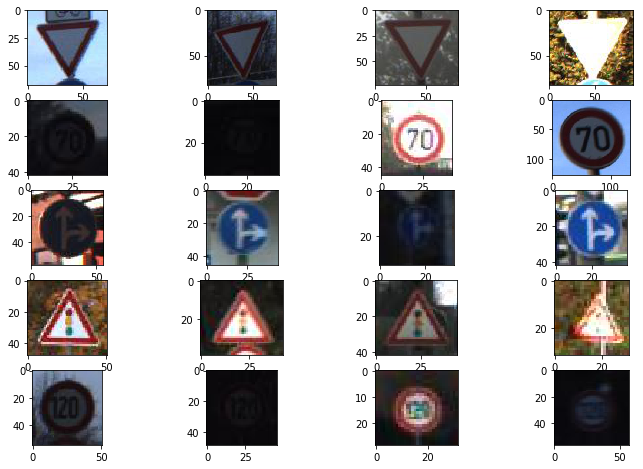

In [0]:
# Show some image
def show_sample():
  ''' The function plots a sample of traffic sign images
  '''

  random_val = []
  for i in range(5):
    random_val.append(random.choice(range(43)))

  sign0 = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[0])))
  sign1 = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[1])))
  sign2 = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[2])))
  sign3 = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[3])))
  sign4 = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[4])))
  sample_data = list()
    
  fig=plt.figure(figsize=(12, 8))
  columns = 4
  rows = 5
  for i in range(columns):
    sample_data.append(os.path.join(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[0])),sign0[i]))
  for i in range(columns):
    sample_data.append(os.path.join(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[1])),sign1[i]))
  for i in range(columns):
    sample_data.append(os.path.join(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[2])),sign2[i]))
  for i in range(columns):
    sample_data.append(os.path.join(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[3])),sign3[i]))
  for i in range(columns):
    sample_data.append(os.path.join(os.path.join(JPG_TRAIN_IMAGE_DIR,  str(random_val[4])),sign4[i]))
    
  for i in range(columns*rows):
      img = simg.imread(sample_data[i])
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(img)
  plt.show()
  
show_sample()

## Data imbalancy check



*   There are 43 types of traffic signs are present in the dataset in image format.
*   It's very clear that all the classes (traffic signs) don't have same amount of images present.
*   We will try to figure out the imbalancy in the dataset and plot it as a `bar plot`



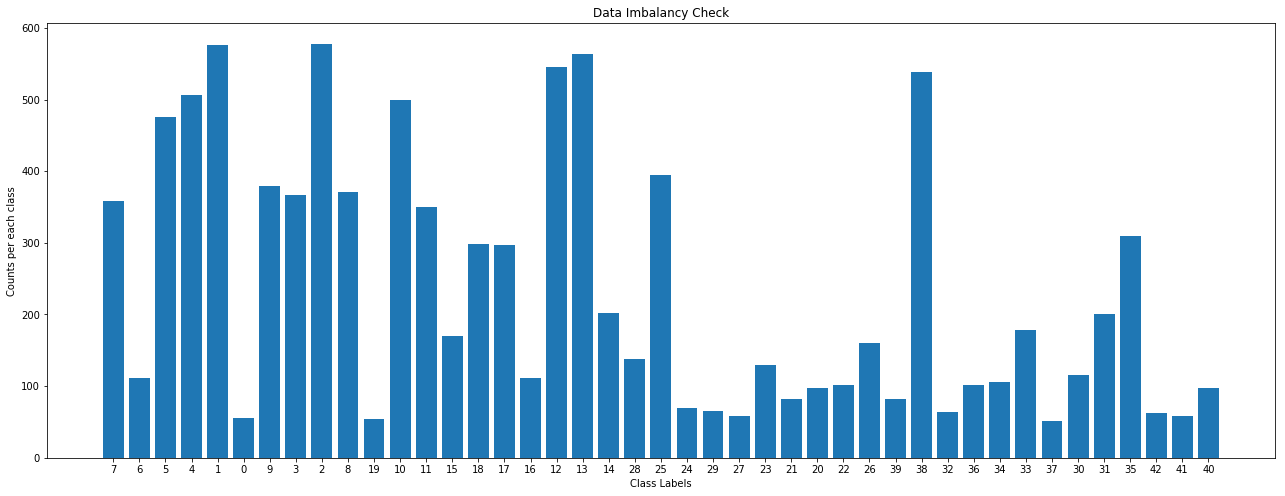

In [0]:
def plot_to_check_balanced_data():
  ''' The function will bar plot the different classes to check if it is balanced or not.

  :description:
              It will count the number of image data for each class in the training dataset.
              A horizontl bar plot will be made from the above calculations.
  '''

  class_names = os.listdir(JPG_TRAIN_IMAGE_DIR)
  total_classes = len(class_names)
  count_per_class = dict()
  for cls in class_names:
    count_per_class[cls] = len(os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR, cls)))
  
  # Plot the data
  fig=plt.figure(figsize=(22, 8))
  plt.bar(range(len(count_per_class)), list(count_per_class.values()), align='center')
  plt.xticks(range(len(count_per_class)), list(count_per_class.keys()))
  plt.title('Data Imbalancy Check')
  plt.xlabel('Class Labels')
  plt.ylabel('Counts per each class')  
  plt.show()

  return count_per_class

count_per_class = plot_to_check_balanced_data()

## Image Augmentation

*   As we can see that the data is highly imbalanced, so using the data might lead to a bad performance.
*   We will use image augmentation techniqu to improve the performance and to balance the data.
*   Below are the different image augmentation techniques we will use:
    *   Resize all the images to same diemnsion.
    *   Rotation of images in degrees (-15, 15, -30, 30, -45, 45, -60, 60, -75, 75, -90, 90)
    *   Fliping the image (horizontal or vertical flips)
    *   Adding Gaussian noise to the images.
    *   Adding light to the images
    *   saturation image
    *   hue image
    *   Rescaling all the images.







In [0]:
class ImageAugmentation:
  ''' The class defined will change the input images by augmenting their actual shapes and sizes
  :description:
              Below are the following augmentation techniques will be used as part of this project.
              1. Resizing all the images to a particular hight and width.
              2. Rotation of the images
              3. Image fliping
              4. Adding gaussian noise to the images
              5. Adding light to the images
              6. Saturation image
              7. Hue image

              We are also using image augmentation to balance the dataset.
                  - We will provide the number of images each class will have.
                  - By using image augmentation we will balance each classes to the above mentioned number.
                  - we will do the image augmentation in a random manner.
  '''

  def __init__(self, img_height, img_width, img_extn='.jpg'):
    ''' Initializing the class
        
        :param img_height: Height of the image after resizing.
        :param img_width: Width of the image after resizing.
        :param img_extn: Extension of the image to be saved as, by default its `.jpg`
    '''

    self.img_height = img_height
    self.img_width = img_width
    self.img_extn = img_extn
    
  def resize_image(self, image):
    ''' The function will resize every image to a specific height and width

        :param image: input image
    '''

    image = cv2.resize(image, (self.img_width, self.img_height))
    return image

  def rotate_image(self, image, rotation_angle, scale=1.0):
    ''' The function will rotate the image in a specific angle.

        :param image: input image
        :param rotation_angle: Angle to which the rotation will happen.
                               Positive angle means anti-clockwise rotation.
                               Negative angle means clockwise rotation.
        :param scale: Scale after rotation, by default 1.0 means to keep the original size
    '''

    M = cv2.getRotationMatrix2D((self.img_width/2, self.img_height/2), rotation_angle, scale)
    image = cv2.warpAffine(image, M, (self.img_width, self.img_height))
    return image

  def flip_image(self, image, direction):
    ''' The function will flip the image either in horizontal or vertical direction.
        
        :param image: input image
        :param direction: Direction to which the image will be flipped (0 : horizontal, 1 : vertical)
    '''

    image = cv2.flip(image, direction)
    return image
  
  def add_gaussian_noise(self, image, mean, stddev):
    ''' The function will add random normal (gaussian) noise to the image
        
        :param image: input image
        :param mean: mean of the distribution
        :param stddev: standard deviation of the distribution
    '''

    gaussian_noise = image.copy()
    cv2.randn(gaussian_noise, mean, stddev)
    image = image + gaussian_noise
    return image

  def add_light(self, image):
    ''' The function will adjust brightness to the images

        :param image: input image
        :param gamma: the rate at which the brightness will be adjusted

        :description:
                    To adjust brightness we will get the original brightness of the image.
                    Based on that we will adjust the brightness.
                    We will use gamma correction here
                         formula : O = ((I/255)^gamma) * 255
    '''

    light_gamma = random.choice([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
    dark_gamma = random.choice([0.67, 0.4, 0.2, 0.1, 0.04])

    temp_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Covert to gray
    temp_img = cv2.blur(temp_img, (5,5)) # blur the image
    if cv2.mean(temp_img)[0] > 127:
      igamma = 1.0/dark_gamma
      lookuptable = np.array([((i / 255.0) ** igamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
      image=cv2.LUT(image, lookuptable)
    else:
      igamma = 1.0/light_gamma
      lookuptable = np.array([((i / 255.0) ** igamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
      image=cv2.LUT(image, lookuptable)
    
    return image

  def saturation_image(self, image, saturation):
    ''' The function will create a saturated image.
        
        :param image: input image
        :param saturation: value of saturation
    '''

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    component = image[:, :, 2]
    component = np.where(component <= 255 - saturation, component + saturation, 255)
    image[:, :, 2] = component
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

  def hue_image(self, image, hue):
    ''' The function will create a hue image.
        
        :param image: input image
        :param hue: value of hue
    '''

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    component = image[:, :, 2]
    component = np.where(component <= 255 + hue, component - hue, 255)
    image[:, :, 2] = component
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

## Balance data using data augmentation


*   The below function will apply image augmentation on the `training images` to balance the data.
    *   At first we will rsize all the `training images` to a certain `height` and `width`.
    *   Then we will randomly take images and apply different data augmentation to balance the data.

* Below is the stpes how augmentation steps worked to balance the data.
    * We will first create one mapping image counts with each and every class.
    * Find the max count among all the classes we calculated in the above step, as we will try to balance rest of the classes based on the max count.
    * Once this is done, we will first resize all the images to a certain height and width (say, 64x64).
    * Then randomly apply different augmentaion techniques on the classes to generate new images and balance them all.


**<font color='green'>NOTE:</font>**

There are some classes (33 to 39) , we will not apply `rotation` and `flip` operations on them as they are providing different directions which might be totally misleading if we apply the above mentioned operations to them.



In [0]:
def balance_data_after_img_aug(img_height, img_width):
  ''' The function will balance the classes using image augmentation
  '''

  # Declaring some parameters related to image augmentation
  img_extn = '.jpg'
  rotation_angle = [15, 30, 45, 60, 75, 90, -15, -30, -45, -6, -75, -90]
  flip_direction = [0, 1]
  mean = 0
  stddev = 0.31623 # square-root of 0.1
  sat_hue = [50, 100, 150, 200]
  exclude_rotation_flip_class = ['33','34','35','36','37','38','39']

  img_aug = ImageAugmentation(img_height, img_width) # Declare the image augmentation class

  class_count_mapping = dict() # Count for each class(traffic sign) in the training dataset
  class_dirs = os.listdir(JPG_TRAIN_IMAGE_DIR)
  total_class = len(class_dirs)
  max_count = 0
  aug_sequence = 1
  img_name_counter = 1

  for dir_ in class_dirs:
    image_files = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR, dir_))
    count_ = len(image_files)
    class_count_mapping[dir_] = count_
    max_count = max(class_count_mapping.values())
  
  for dir_ in class_dirs:
    image_files = os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR, dir_))
    # The following for loop will do the resizing of all the images available
    for img_file in image_files:
      img_file_pull_path = os.path.join(JPG_TRAIN_IMAGE_DIR, dir_, img_file)
      image_data = cv2.imread(img_file_pull_path)
      image_data = img_aug.resize_image(image_data)
      os.remove(img_file_pull_path)
      cv2.imwrite(img_file_pull_path, image_data)
    
    while(class_count_mapping[dir_] != max_count):
      img_file_pull_path = os.path.join(JPG_TRAIN_IMAGE_DIR, dir_, img_file)
      new_img_file_full_path = os.path.join(JPG_TRAIN_IMAGE_DIR, dir_, img_file.split('.')[0]+'_'+str(img_name_counter)+'.'+img_file.split('.')[1])
      image_data = cv2.imread(img_file_pull_path)

      img_file = random.choice(image_files)
      if aug_sequence == 1:
        if dir_ not in exclude_rotation_flip_class:
          image_data = img_aug.rotate_image(image_data, random.choice(rotation_angle))
          cv2.imwrite(new_img_file_full_path, image_data)
          class_count_mapping[dir_] = class_count_mapping[dir_] + 1
          aug_sequence += 1
          img_name_counter += 1
        else:
          aug_sequence += 1
          img_name_counter += 1
      elif aug_sequence == 2:
        if dir_ not in exclude_rotation_flip_class:
          image_data = img_aug.flip_image(image_data, random.choice(flip_direction))
          cv2.imwrite(new_img_file_full_path, image_data)
          class_count_mapping[dir_] = class_count_mapping[dir_] + 1
          aug_sequence += 1
          img_name_counter += 1
        else:
          aug_sequence += 1
          img_name_counter += 1
      elif aug_sequence == 3:
        image_data = img_aug.add_gaussian_noise(image_data, mean, stddev)
        cv2.imwrite(new_img_file_full_path, image_data)
        class_count_mapping[dir_] = class_count_mapping[dir_] + 1
        aug_sequence += 1
        img_name_counter += 1
      elif aug_sequence == 4:
        image_data = img_aug.add_light(image_data)
        cv2.imwrite(new_img_file_full_path, image_data)
        class_count_mapping[dir_] = class_count_mapping[dir_] + 1
        aug_sequence += 1
        img_name_counter += 1
      elif aug_sequence == 5:
        image_data = img_aug.saturation_image(image_data, random.choice(sat_hue))
        cv2.imwrite(new_img_file_full_path, image_data)
        class_count_mapping[dir_] = class_count_mapping[dir_] + 1
        aug_sequence += 1
        img_name_counter += 1
      elif aug_sequence == 6:
        image_data = img_aug.hue_image(image_data, random.choice(sat_hue))
        cv2.imwrite(new_img_file_full_path, image_data)
        class_count_mapping[dir_] = class_count_mapping[dir_] + 1
        aug_sequence = 1
        img_name_counter += 1
    print('Image augmentation done for directory {}'.format(dir_))


**<font color='red'>CAUTION:</font>**



*   The above code to convert the .ppm to .jpg and creating the folder structure might take few seconds in local systems, but on `Google Colab` it will take a little more time and also it might fail as <font color='blue'>Drive FUSE operations can time out when the number of files in a directory becomes large</font>, then you have to re-run it more than one time.
*    Do comment the below function call once you have run it successfully once, just to avoid re-running the same accidentally again (as it will take some time)



In [0]:
# Uncomment the below function call for the first time the do comment just to avoid re-doing the same thing
# balance_data_after_img_aug(IMG_HEIGHT, IMG_WIDTH)

Image augmentation done for directory 7
Image augmentation done for directory 6
Image augmentation done for directory 5
Image augmentation done for directory 4
Image augmentation done for directory 1
Image augmentation done for directory 0
Image augmentation done for directory 9
Image augmentation done for directory 3
Image augmentation done for directory 2
Image augmentation done for directory 8
Image augmentation done for directory 19
Image augmentation done for directory 10
Image augmentation done for directory 11
Image augmentation done for directory 15
Image augmentation done for directory 18
Image augmentation done for directory 17
Image augmentation done for directory 16
Image augmentation done for directory 12
Image augmentation done for directory 13
Image augmentation done for directory 14
Image augmentation done for directory 28
Image augmentation done for directory 25
Image augmentation done for directory 24
Image augmentation done for directory 29
Image augmentation done fo

### Data is balanced now

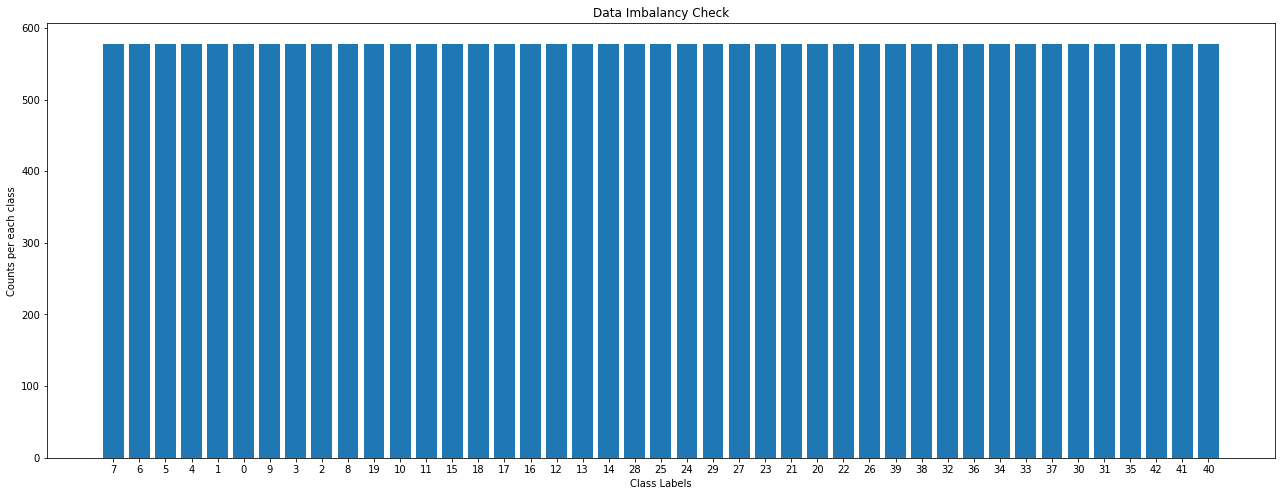

In [0]:
count_per_class = plot_to_check_balanced_data()

## Building Deep Learning Model (CNN)


*   We will first try to build a simple `Convolution Neural Netwrok` model for this purpose.
* Below are the steps that are followed:
    * <font color='blue'>[STEP-1]</font>: At first we will count total number of images in each of the thress sets (Training directory, Test directory and validation directory).
    * <font color='blue'>[STEP-2]</font>: Define model parameters like **number of epochs**, **learning rate** and **batch size**.
    * <font color='blue'>[STEP-3]</font>: The we are rescaling(normalizing) the images using **ImageDataGenerator**.
    * <font color='blue'>[STEP-4]</font>: As we have all the class level images into different directories **flow_from_directory** method which is useful in such cases.
    * <font color='blue'>[STEP-5]</font>: Define the **CNN** model.
    * <font color='blue'>[STEP-6]</font>: It's always better to decay the learning rate for every epoch.
    * <font color='blue'>[STEP-7]</font>: Compile the model (**Adam** optimizer is used).
    * <font color='blue'>[STEP-8]</font>: Train(Fit) the model.
    * <font color='blue'>[STEP-9]</font>: Save all the model related details.
    * <font color='blue'>[STEP-10]</font>: Display the model structure.
    * <font color='blue'>[STEP-11]</font>: Plt the `accuracy` and `loss` vs `epochs`.
    * <font color='blue'>[STEP-12]</font>: Testing(Prediction) phase.
    * <font color='blue'>[STEP-13]</font>: Confusion matrix.



### <font color='blue'>[STEP-1]</font>

In [0]:
# Get the total count of train, test & validation images
total_img_count_dict = dict()

train_sub_dirs_ = os.listdir(JPG_TRAIN_IMAGE_DIR)
test_sub_dirs_ = os.listdir(JPG_TEST_IMAGE_DIR)
val_sub_dirs_ = os.listdir(JPG_VAL_IMAGE_DIR)

# Total training images count
total_count = 0
for dir_ in train_sub_dirs_:
  total_count += len(os.listdir(os.path.join(JPG_TRAIN_IMAGE_DIR, dir_)))
total_img_count_dict['train'] = total_count

# Total testing images count
total_count = 0
for dir_ in test_sub_dirs_:
  total_count += len(os.listdir(os.path.join(JPG_TEST_IMAGE_DIR, dir_)))
total_img_count_dict['test'] = total_count

# Total validation images count
total_count = 0
for dir_ in val_sub_dirs_:
  total_count += len(os.listdir(os.path.join(JPG_VAL_IMAGE_DIR, dir_)))
total_img_count_dict['val'] = total_count

### <font color='blue'>[STEP-2]</font>

In [0]:
# Define model parameter
epochs = 20 # No of iterations to be performed for the model while training
learning_rate = 1e-3 # step size for the optimizer
batch_size = 32 # number of images on a single batch

### <font color='blue'>[STEP-3]</font>

In [0]:
# rescaling the images using `ImageDataGenerator`
training_augmentation = ImageDataGenerator(rescale=1 / 255.0)
validation_testing_augmentation = ImageDataGenerator(rescale=1 / 255.0)

### <font color='blue'>[STEP-4]</font>

In [0]:
# Initialize data generator
# Here we are creating three generators for train, test and validation
# The `flow_from_directory` method will get all the images from the parent directory.
# The classes will the subdirectory name

# Initialize training generator
training_generator = training_augmentation.flow_from_directory(
	                                                             JPG_TRAIN_IMAGE_DIR,
	                                                             class_mode="categorical",
	                                                             target_size=(32, 32),
	                                                             color_mode="rgb",
	                                                             shuffle=True,
	                                                             batch_size=batch_size
                                                              )
 
# initialize the validation generator
validation_generator = validation_testing_augmentation.flow_from_directory(
	                                                                         JPG_VAL_IMAGE_DIR,
	                                                                         class_mode="categorical",
	                                                                         target_size=(32, 32),
	                                                                         color_mode="rgb",
	                                                                         shuffle=False,
	                                                                         batch_size=batch_size
                                                                          )
 
# initialize the testing generator
testing_generator = validation_testing_augmentation.flow_from_directory(
	                                                                       JPG_TEST_IMAGE_DIR,
	                                                                       class_mode="categorical",
	                                                                       target_size=(32, 32),
	                                                                       color_mode="rgb",
	                                                                       shuffle=False,
	                                                                       batch_size=batch_size
                                                                        )

Found 24854 images belonging to 43 classes.
Found 3709 images belonging to 43 classes.
Found 3730 images belonging to 43 classes.


### <font color='blue'>[STEP-5]</font>

In [0]:
def basic_cnn_model():
  ''' This our baisc CNN model to be trained.
      :component:
                1. CONV layer of 32 filters of size 3x3 and padding same
                2. CONV layer of 32 filters of size 3x3
                3. Maxpooling layer of size 2x2
                4. Dropout layer with rate 0.2 (20%)
                5. CONV layer of 64 filters of size 3x3 and padding same
                6. CONV layer of 64 filters of size 3x3
                7. Maxpooling layer of size 2x2
                8. Dropout layer with rate 0.2 (20%)
                9. CONV layer of 128 filters of size 3x3 and padding same
                10. CONV layer of 128 filters of size 3x3
                11. Maxpooling layer of size 2x2
                12. Dropout layer with rate 0.2 (20%)
                13. Dense layer with 512 neurons
                14. Softmax layer with 43 neurons
                ** Activation function is RELU
  '''
  if K.image_data_format() == 'channels_first':
    dim_ = (3, 32, 32)
  elif K.image_data_format() == 'channels_last':
    dim_ = (32, 32, 3)

  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same',
                    input_shape=dim_,
                    activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), padding='same',
                    activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), padding='same',
                    activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  return model

### <font color='blue'>[STEP-6]</font>

In [0]:
# Function to decaying learning rate
def step_decay(epoch):
  ''' The function will decay the learning rate after each epoc.
      :param epoch: epoch
  '''
  lrate = learning_rate * (1 - (epoch / float(epochs))) ** 1.0
  return lrate

callbacks = [LearningRateScheduler(step_decay)]

### <font color='blue'>[STEP-7]</font>

In [0]:
# Instantiating the model
model = basic_cnn_model()

# using `ADAM` optimizer
optimizer = Adam(lr=learning_rate)

# For multiclass classification we are using `categorical_crossentropy` as loss
# And as the data is balanced so we are using `Accuracy as our performance metric`
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### <font color='blue'>[STEP-8]</font>

In [0]:
# Fitting the model
history = model.fit_generator(
	training_generator,
	steps_per_epoch=total_img_count_dict['train'] // batch_size,
	validation_data=validation_generator,
	validation_steps=total_img_count_dict['val'] // batch_size,
	epochs=epochs,
	callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





776/776 [==============================] - 59s 76ms/step - loss: 2.5787 - acc: 0.2475 - val_loss: 1.3333 - val_acc: 0.5685
Epoch 2/20
776/776 [==============================] - 51s 66ms/step - loss: 1.2353 - acc: 0.6210 - val_loss: 0.4290 - val_acc: 0.8569
Epoch 3/20
776/776 [==============================] - 51s 66ms/step - loss: 0.7304 - acc: 0.7770 - val_loss: 0.2381 - val_acc: 0.9290
Epoch 4/20
776/776 [==============================] - 51s 66ms/step - loss: 0.5261 - acc: 0.8397 - val_loss: 0.2013 - val_acc: 0.9315
Epoch 5/20
776/776 [==============================] - 51s 66ms/step - loss: 0.4220 - acc: 0.8700 - val_loss: 0.1495 - val_acc: 0.9513
Epoch 6/20
776/776 [==============================] - 53s 69ms/step - loss: 0.3474 - acc: 0.8904 - val_loss: 0.1051 - val_acc: 0.9687
Epoch 7/20
776/776 [==============================] - 51s 66ms/step - loss: 0.3017 - acc: 0.90

### <font color='blue'>[STEP-9]</font>

In [0]:
def pickel_unpicke_objects(filename, obj=None, todo='pickle'):
  ''' The function will pickle or unpickle a python object to a file
      
      :param filename: full path of the filename where the object will be pickled
      :param obj: The pyhton object
      :param todo: either pickle or unpickle

      :description:
                  when we will pickle we have to specify all the parameters mentioned above and todo='pickle'
                  when we will unpickle we dont have to specify obj as parameter, and todo='unpickle'
                  while unpickling give the filename where the object resides else nothing will be returned.
  '''

  if todo == 'pickle':
    fileobj = open(filename, 'wb')
    pickle.dump(obj, fileobj)
    fileobj.close()
  elif todo == 'unpickle':
    fileobj = open(filename, 'rb')
    ret_obj = pickle.load(fileobj)
    fileobj.close()
    return ret_obj

def save_load_model(filename, model=None, todo='save'):
  ''' The function will save or load a keras model to a file
      
      :param filename: full path of the filename where the model will be saved (file extn should be `.h5`)
      :param model: The keras model
      :param todo: either save or load

      :description:
                  when we will save we have to specify all the parameters mentioned above and todo='save'
                  when we will load we dont have to specify model as parameter, and todo='load'
                  while loading give the filename where the model resides else nothing will be returned.
  '''

  if todo == 'save':
    model.save(filename)
  elif todo == 'load':
    ret_model = load_model(filename)
    return ret_model

## Please follow the below instruction to choose the above functionality wisely
## For the first time when the model is trained.
## We get the below things handy:
##        1. The model itself
##        2. The history
##        3. the prediction stats after testing
## So when ever we are changing the models and trying to train and test the same we get the above parameter are changed
## Then we have save the model and pickle the parameters to the file
## To reuse the same we have to load or unpickele them.

# save_load_model(BASIC_MODEL_FILE, model, 'save')
# model = save_load_model(BASIC_MODEL_FILE, todo='load')

# pickel_unpicke_objects(BASIC_MODEL_HISTORY, history, 'pickle')
# history = pickel_unpicke_objects(BASIC_MODEL_HISTORY, todo='unpickle')

# plot_model(model, to_file=BASIC_MODEL_IMAGE, show_shapes=True, show_layer_names=True)


### <font color='blue'>[STEP-10]</font>

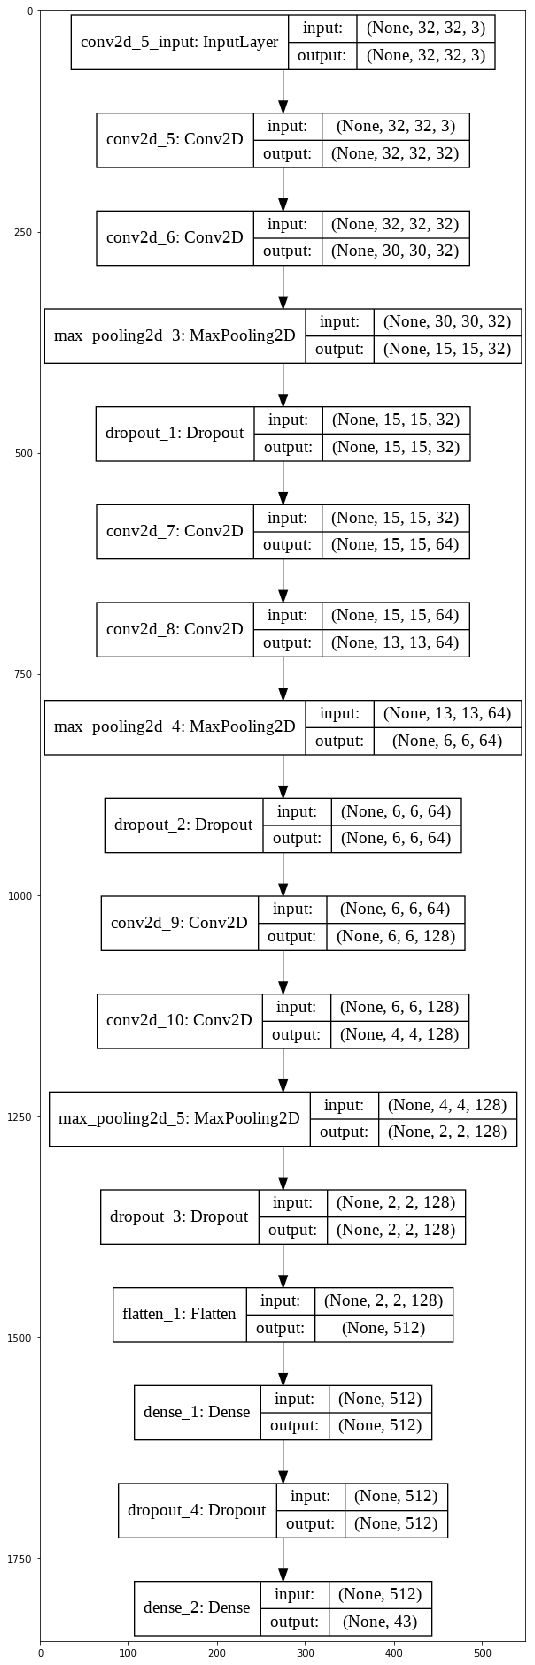

In [0]:
# Plotting the model architecture
plt.figure(figsize=(15, 30))
plt.imshow(cv2.imread(BASIC_MODEL_IMAGE))

### <font color='blue'>[STEP-11]</font>

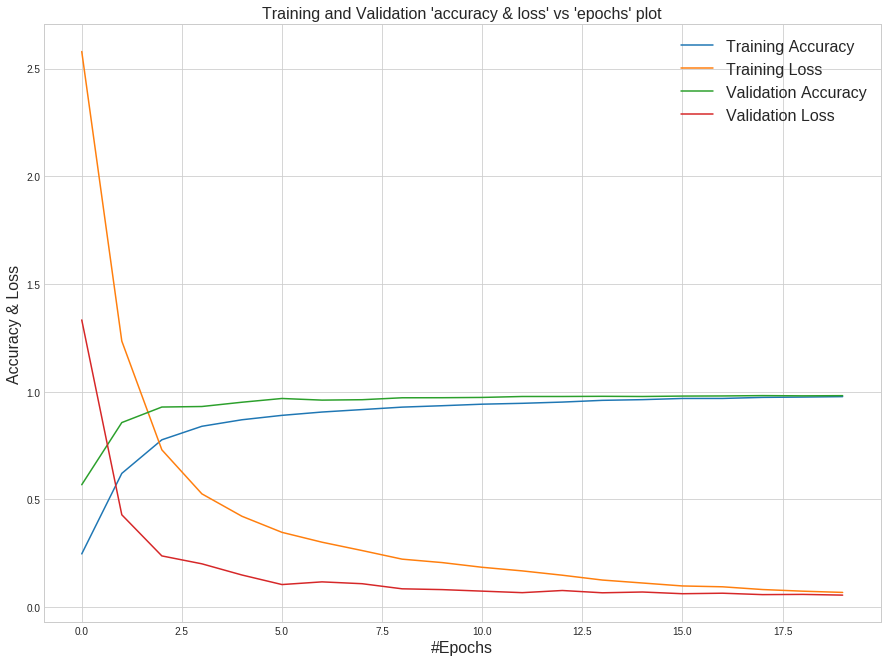

In [0]:
def plot_loss_accuracy(history):
  ''' The function will plot the training and validation loss & accuracy vs epochs
      :param history: the history object after model training
  '''
  
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure(figsize=(15, 11))
  ax = plt.axes()
  x = list(range(epochs))
  y1 = history.history['acc']
  y2 = history.history['loss']
  y3 = history.history['val_acc']
  y4 = history.history['val_loss']

  plt.plot(x, y1, label='Training Accuracy')
  plt.plot(x, y2, label='Training Loss')
  plt.plot(x, y3, label='Validation Accuracy')
  plt.plot(x, y4, label='Validation Loss')

  plt.title('Training and Validation \'accuracy & loss\' vs \'epochs\' plot', fontsize=16)
  plt.xlabel('#Epochs', fontsize=16)
  plt.ylabel('Accuracy & Loss', fontsize=16)

  plt.legend(prop={'size': 16});

plot_loss_accuracy(history)

### <font color='blue'>[STEP-12]</font>

In [0]:
# Prediction phase
testing_generator.reset()
prediction_stats = model.predict_generator(testing_generator, steps=(total_img_count_dict['test'] // batch_size) + 1)

In [0]:
# Pickel the prediction stats
# pickel_unpicke_objects(BASIC_MODEL_PREDICTION, prediction_stats, 'pickle')
# prediction_stats = pickel_unpicke_objects(BASIC_MODEL_PREDICTION, todo='unpickle')

### <font color='blue'>[STEP-13]</font>

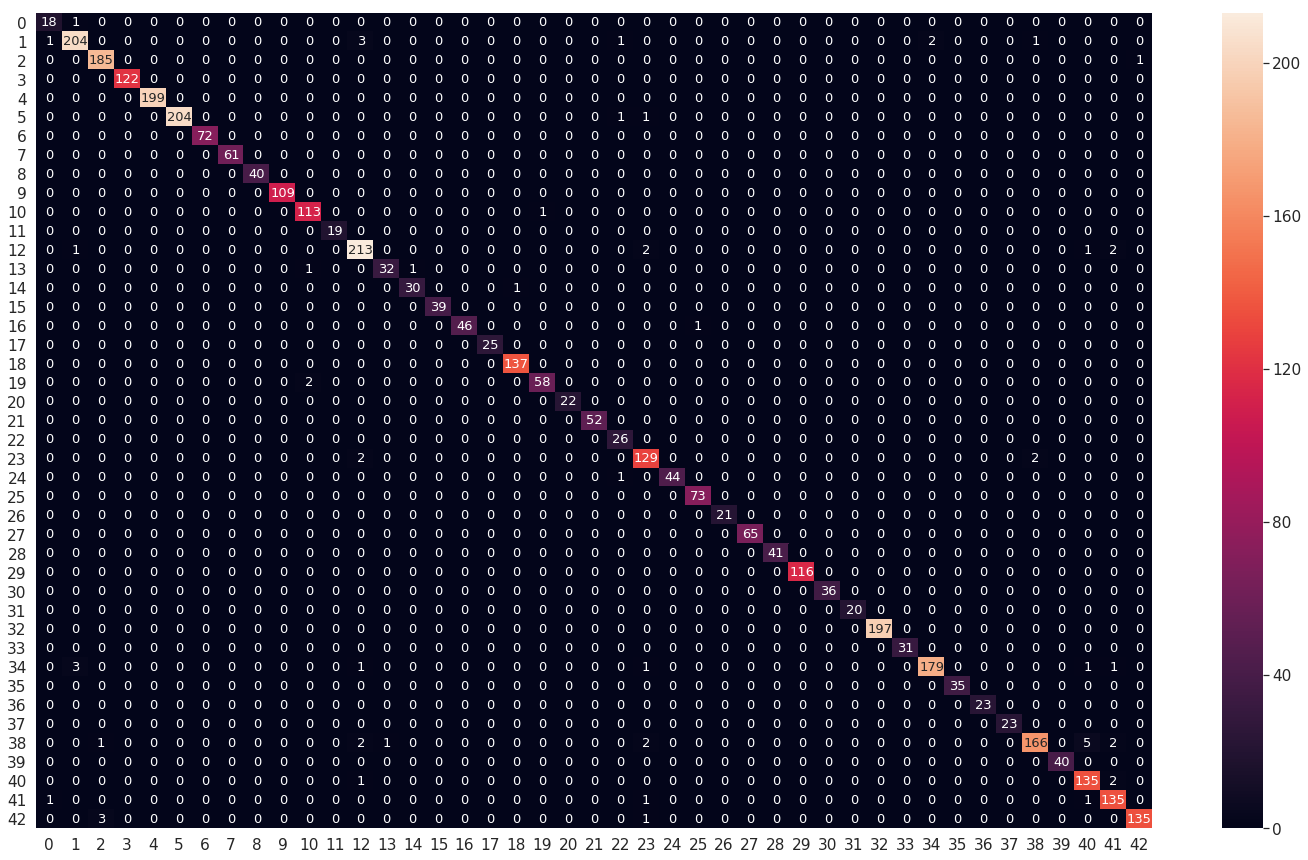

In [0]:
# Confusion matrix
prediction_stats_max = np.argmax(prediction_stats, axis=1)
df_cm = pd.DataFrame(confusion_matrix(testing_generator.classes, prediction_stats_max), range(43),range(43))
plt.figure(figsize=(25,15))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 13}, fmt='g')

## Observations:
*  We can surely observe that the basic CNN model (no fanct Nets were used) gives a very good performance on the data.
    
    *  **Constraints:**
        *  We have used only a fraction of the whole data for the training purpose due to lack of processing power.
        *  Not all kind or variance of data is used for training which would make the training process more robust.

    *  **What we did better:**
        *  Image augmentation, a powerful tool, that helped us bringing up the performance.
        *  Random image augmentation also helped to increase the variance of the data as well as balancing the data by creating artifical images.
    *  **What next:**
        *  Although our basic CNN model gives us a very promising perfomance, still we will try to explore another model to check how it performs on the same (just experimental purpose).
        *  Our next model of experiment will be **<font color='blue'>Multi Scale CNN (MCNN)</font>**.